In [71]:
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from pesummary.gw.conversions.mass import component_masses_from_mchirp_q, q_from_eta
from pycbc import psd as psd_func
from pycbc.filter import sigma, match, matched_filter
from pycbc.filter.matchedfilter import quadratic_interpolate_peak
from pycbc.noise import frequency_noise_from_psd
from simple_pe.waveforms import make_waveform, calc_f_gen, two_ecc_harms_SNR, calculate_mode_snr, generate_eccentric_waveform_MA
from calcwf import match_hn

# Disable pesummary warnings
import logging
_logger = logging.getLogger('PESummary')
_logger.setLevel(logging.CRITICAL + 10)

# Otherwise plt.savefig crashes with latex errors
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# e=0.2, chirp=24

In [2]:
# Data settings
true_dict = {'ecc10sqrd': 0.2**2, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
target_snr = 20
f_low = 20
sample_rate = 4096
tlen = 32

# Create psd
ifos = ['H1']
psds = {'H1': 'aLIGOZeroDetHighPower',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])
psd['harm'] = 1. / sum([1. / psd[ifo] for ifo in ifos])

# Generate data
true_dict['mass_ratio'] = q_from_eta(true_dict['symmetric_mass_ratio'])
true_dict['inverted_mass_ratio'] = 1/true_dict['mass_ratio']
true_dict['total_mass'] = np.sum(component_masses_from_mchirp_q(true_dict['chirp_mass'], true_dict['mass_ratio']), axis=0)
true_dict['distance'] = 1
data = make_waveform(true_dict.copy(), psd['harm'].delta_f, f_low, len(psd['harm']), approximant='TEOBResumS-Dali')
raw_snr = sigma(data, psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
data = {'H1': data.to_timeseries()*target_snr/raw_snr}
true_dict['distance'] = raw_snr/target_snr

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:390: RuntimeWarning: divide by zero encountered in divide
  return self._data.__rtruediv__(other)


## Performing direct match to data

### Exact degeneracy line

In [3]:
# Get degeneracy line in roughly correct direction
with open('pe_4d_pipeline/dataslot_0/all_matches', 'rb') as fp:
    all_matches = pickle.load(fp)
base_dict = all_matches['metadata']['base_params']
fid_dict = all_matches['metadata']['fid_params']

# Shift degeneracy line to pass through true point
mult = true_dict['ecc10sqrd']/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
for key in ['chirp_mass', 'symmetric_mass_ratio', 'chi_eff']:
    proj_point = mult*(fid_dict[key]-base_dict[key])+base_dict[key]
    proj_diff = true_dict[key]-proj_point
    base_dict[key] += proj_diff
    fid_dict[key] += proj_diff

In [15]:
# Loop over distance along degeneracy line
data_ecc_SNRs_ = []
trial_ecc_SNRs_ = []
data_matches_ = []
param_keys = ['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff']
e10s_ = np.linspace(0.1, 0.3, 21)
for i, e10 in enumerate(e10s_):
    dist = (e10**2-base_dict['ecc10sqrd'])/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
    params = {'distance': 1}
    for param in param_keys:
        params[param] = dist*(fid_dict[param]-base_dict[param])+base_dict[param]

    # Make eccentric harmonics and match to data
    ecc_harms = make_waveform(params, psd['H1'].delta_f, f_low, len(psd['H1']), approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4)
    wf_hjs = [ecc_harms[k].to_timeseries() for k in [0, 1, -1, 2]]
    f_gen = calc_f_gen(f_low, 4)
    match_cplx = match_hn(wf_hjs, data['H1'], f_gen, psd=psd['H1'], f_match=f_low)
    # data_ecc_SNR = np.abs(match_cplx[1])/np.abs(match_cplx[0])
    # target_MA = (np.angle(match_cplx[1])-np.angle(match_cplx[0])) % (2*np.pi)
    data_ecc_SNR, target_MA = two_ecc_harms_SNR({0: np.abs(match_cplx[0]), 1: np.abs(match_cplx[1]), -1: np.abs(match_cplx[2])},
                                                {0: np.angle(match_cplx[0]), 1: np.angle(match_cplx[1]), -1: np.angle(match_cplx[2])})
    data_ecc_SNR = data_ecc_SNR*np.exp(1j*target_MA)
    data_ecc_SNRs_.append(np.abs(data_ecc_SNR))
    
    # Calculate trial waveform with correct MA and match to data
    two_ecc_harms=True
    params['inverted_mass_ratio'] = 1/q_from_eta(params['symmetric_mass_ratio'])
    params['total_mass'] = np.sum(component_masses_from_mchirp_q(params['chirp_mass'], params['inverted_mass_ratio']))
    trial_wf = generate_eccentric_waveform_MA(params['total_mass'], params['inverted_mass_ratio'],
                                              params['ecc10sqrd']**0.5, params['chi_eff'], params['chi_eff'],
                                              psd['H1'], f_low, target_MA, ecc_harms, two_ecc_harms=two_ecc_harms)
    data_match, _ = match(data['H1'], trial_wf, psd=psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
    data_matches_.append(data_match)

    # Match trial waveform to eccentric harmonics
    trial_z, _ = calculate_mode_snr(trial_wf, psd['H1'], ecc_harms, trial_wf.sample_times[0],
                                    trial_wf.sample_times[-1], f_low, ecc_harms.keys(),
                                    dominant_mode=0)
    if two_ecc_harms:
        harm_ids = [0, 1, -1]
        ecc_SNR_abs, ecc_SNR_ang = two_ecc_harms_SNR(
            {k: np.abs(trial_z[k]) for k in harm_ids},
            {k: np.angle(trial_z[k]) for k in harm_ids})
    else:
        ecc_SNR_abs = np.abs(trial_z[1]/trial_z[0])
        ecc_SNR_ang = (np.angle(trial_z[1])-np.angle(trial_z[0])) % (2*np.pi)
    trial_ecc_SNR = ecc_SNR_abs*np.exp(1j*ecc_SNR_ang)
    trial_ecc_SNRs_.append(np.abs(trial_ecc_SNR))

    print(f'\r{i+1} complete out of {len(e10s_)}', end='')

1 complete out of 21


KeyboardInterrupt



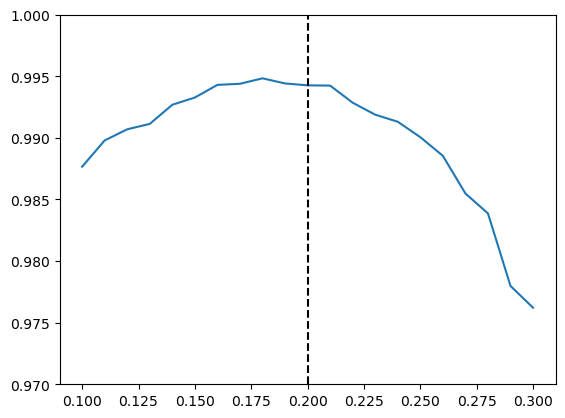

In [7]:
# Plot results
plt.plot(e10s_, data_matches_)
plt.ylim(0.97,1)
plt.axvline(true_dict['ecc10sqrd']**0.5, c='k', ls='dashed')
plt.show()

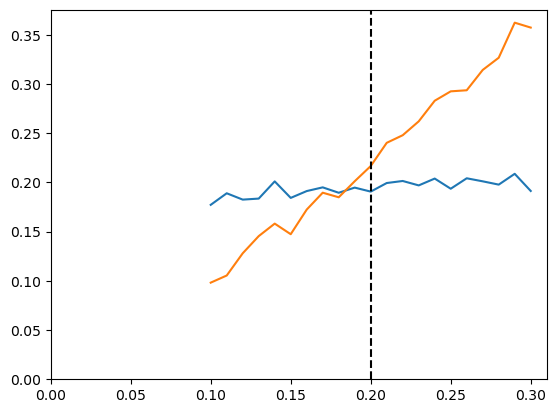

In [8]:
# Plot results
plt.plot(e10s_, data_ecc_SNRs_)
plt.plot(e10s_, trial_ecc_SNRs_)
plt.axvline(true_dict['ecc10sqrd']**0.5, c='k', ls='dashed')
plt.ylim(0,)
plt.xlim(0,)
plt.show()

### Imperfect degeneracy line

In [9]:
# Get degeneracy line in roughly correct direction
with open('pe_4d_pipeline/dataslot_0/all_matches', 'rb') as fp:
    all_matches = pickle.load(fp)
base_dict = all_matches['metadata']['base_params']
fid_dict = all_matches['metadata']['fid_params']

In [12]:
# Loop over distance along degeneracy line
data_ecc_SNRs__ = []
trial_ecc_SNRs__ = []
data_matches__ = []
param_keys = ['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff']
e10s__ = np.linspace(0.05, 0.25, 21)
for i, e10 in enumerate(e10s__):
    dist = (e10**2-base_dict['ecc10sqrd'])/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
    params = {'distance': 1}
    for param in param_keys:
        params[param] = dist*(fid_dict[param]-base_dict[param])+base_dict[param]

    # Make eccentric harmonics and match to data
    ecc_harms = make_waveform(params, psd['H1'].delta_f, f_low, len(psd['H1']), approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4)
    wf_hjs = [ecc_harms[k].to_timeseries() for k in [0, 1, -1, 2]]
    f_gen = calc_f_gen(f_low, 4)
    match_cplx = match_hn(wf_hjs, data['H1'], f_gen, psd=psd['H1'], f_match=f_low)
    # data_ecc_SNR = np.abs(match_cplx[1])/np.abs(match_cplx[0])
    # target_MA = (np.angle(match_cplx[1])-np.angle(match_cplx[0])) % (2*np.pi)
    data_ecc_SNR, target_MA = two_ecc_harms_SNR({0: np.abs(match_cplx[0]), 1: np.abs(match_cplx[1]), -1: np.abs(match_cplx[2])},
                                                {0: np.angle(match_cplx[0]), 1: np.angle(match_cplx[1]), -1: np.angle(match_cplx[2])})
    data_ecc_SNR = data_ecc_SNR*np.exp(1j*target_MA)
    data_ecc_SNRs__.append(np.abs(data_ecc_SNR))
    
    # Calculate trial waveform with correct MA and match to data
    two_ecc_harms=True
    params['inverted_mass_ratio'] = 1/q_from_eta(params['symmetric_mass_ratio'])
    params['total_mass'] = np.sum(component_masses_from_mchirp_q(params['chirp_mass'], params['inverted_mass_ratio']))
    trial_wf = generate_eccentric_waveform_MA(params['total_mass'], params['inverted_mass_ratio'],
                                              params['ecc10sqrd']**0.5, params['chi_eff'], params['chi_eff'],
                                              psd['H1'], f_low, target_MA, ecc_harms, two_ecc_harms=two_ecc_harms)
    data_match, _ = match(data['H1'], trial_wf, psd=psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
    data_matches__.append(data_match)

    # Match trial waveform to eccentric harmonics
    trial_z, _ = calculate_mode_snr(trial_wf, psd['H1'], ecc_harms, trial_wf.sample_times[0],
                                    trial_wf.sample_times[-1], f_low, ecc_harms.keys(),
                                    dominant_mode=0)
    if two_ecc_harms:
        harm_ids = [0, 1, -1]
        ecc_SNR_abs, ecc_SNR_ang = two_ecc_harms_SNR(
            {k: np.abs(trial_z[k]) for k in harm_ids},
            {k: np.angle(trial_z[k]) for k in harm_ids})
    else:
        ecc_SNR_abs = np.abs(trial_z[1]/trial_z[0])
        ecc_SNR_ang = (np.angle(trial_z[1])-np.angle(trial_z[0])) % (2*np.pi)
    trial_ecc_SNR = ecc_SNR_abs*np.exp(1j*ecc_SNR_ang)
    trial_ecc_SNRs__.append(np.abs(trial_ecc_SNR))

    print(f'\r{i+1} complete out of {len(e10s__)}', end='')

21 complete out of 21

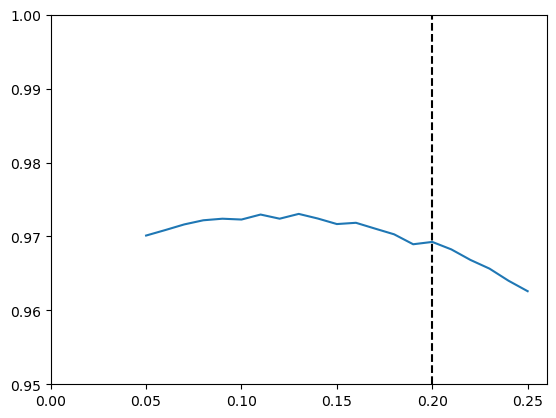

In [13]:
# Plot results
plt.plot(e10s__, data_matches__)
plt.ylim(0.95,1)
plt.xlim(0,)
plt.axvline(true_dict['ecc10sqrd']**0.5, c='k', ls='dashed')
plt.show()

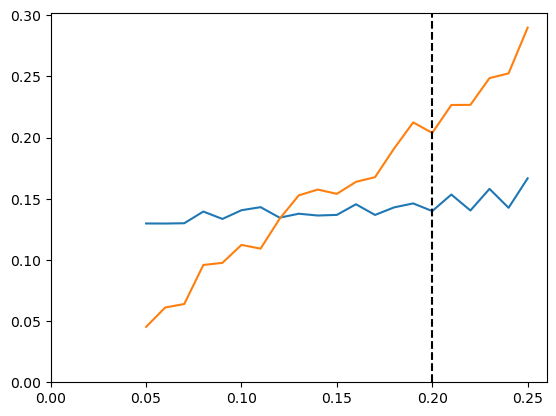

In [14]:
# Plot results
plt.plot(e10s__, data_ecc_SNRs__)
plt.plot(e10s__, trial_ecc_SNRs__)
plt.axvline(true_dict['ecc10sqrd']**0.5, c='k', ls='dashed')
plt.ylim(0,)
plt.xlim(0,)
plt.show()

# e=0.3, chirp=16

In [ ]:
# Data settings
true_dict = {'ecc10sqrd': 0.3**2, 'chirp_mass': 16, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
target_snr = 20
f_low = 20
sample_rate = 4096
tlen = 32

# Create psd
ifos = ['H1']
psds = {'H1': 'aLIGOZeroDetHighPower',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])
psd['harm'] = 1. / sum([1. / psd[ifo] for ifo in ifos])

# Generate data
true_dict['mass_ratio'] = q_from_eta(true_dict['symmetric_mass_ratio'])
true_dict['inverted_mass_ratio'] = 1/true_dict['mass_ratio']
true_dict['total_mass'] = np.sum(component_masses_from_mchirp_q(true_dict['chirp_mass'], true_dict['mass_ratio']), axis=0)
true_dict['distance'] = 1
data = make_waveform(true_dict.copy(), psd['harm'].delta_f, f_low, len(psd['harm']), approximant='TEOBResumS-Dali')
raw_snr = sigma(data, psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
data = {'H1': data.to_timeseries()*target_snr/raw_snr}
true_dict['distance'] = raw_snr/target_snr

## Performing direct match to data

### Exact degeneracy line

In [ ]:
# Get degeneracy line in roughly correct direction
with open('pe_4d_pipeline/dataslot_1/all_matches', 'rb') as fp:
    all_matches = pickle.load(fp)
base_dict = all_matches['metadata']['base_params']
fid_dict = all_matches['metadata']['fid_params']

# Shift degeneracy line to pass through true point
mult = true_dict['ecc10sqrd']/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
for key in ['chirp_mass', 'symmetric_mass_ratio', 'chi_eff']:
    proj_point = mult*(fid_dict[key]-base_dict[key])+base_dict[key]
    proj_diff = true_dict[key]-proj_point
    base_dict[key] += proj_diff
    fid_dict[key] += proj_diff

In [ ]:
# Loop over distance along degeneracy line
data_ecc_SNRs_ = []
trial_ecc_SNRs_ = []
data_matches_ = []
param_keys = ['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff']
e10s = np.linspace(0, 0.5, 21)
for i, e10 in enumerate(e10s):
    dist = (e10**2-base_dict['ecc10sqrd'])/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
    params = {'distance': 1}
    for param in param_keys:
        params[param] = dist*(fid_dict[param]-base_dict[param])+base_dict[param]

    # Make eccentric harmonics and match to data
    ecc_harms = make_waveform(params, psd['H1'].delta_f, f_low, len(psd['H1']), approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4)
    wf_hjs = [ecc_harms[k].to_timeseries() for k in [0, 1, -1, 2]]
    f_gen = calc_f_gen(f_low, 4)
    match_cplx = match_hn(wf_hjs, data['H1'], f_gen, psd=psd['H1'], f_match=f_low)
    # data_ecc_SNR = np.abs(match_cplx[1])/np.abs(match_cplx[0])
    # target_MA = (np.angle(match_cplx[1])-np.angle(match_cplx[0])) % (2*np.pi)
    data_ecc_SNR, target_MA = two_ecc_harms_SNR({0: np.abs(match_cplx[0]), 1: np.abs(match_cplx[1]), -1: np.abs(match_cplx[2])},
                                                {0: np.angle(match_cplx[0]), 1: np.angle(match_cplx[1]), -1: np.angle(match_cplx[2])})
    data_ecc_SNR = data_ecc_SNR*np.exp(1j*target_MA)
    data_ecc_SNRs_.append(np.abs(data_ecc_SNR))
    
    # Calculate trial waveform with correct MA and match to data
    two_ecc_harms=True
    params['inverted_mass_ratio'] = 1/q_from_eta(params['symmetric_mass_ratio'])
    params['total_mass'] = np.sum(component_masses_from_mchirp_q(params['chirp_mass'], params['inverted_mass_ratio']))
    trial_wf = generate_eccentric_waveform_MA(params['total_mass'], params['inverted_mass_ratio'],
                                              params['ecc10sqrd']**0.5, params['chi_eff'], params['chi_eff'],
                                              psd['H1'], f_low, target_MA, ecc_harms, two_ecc_harms=two_ecc_harms)
    data_match, _ = match(data['H1'], trial_wf, psd=psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
    data_matches_.append(data_match)

    # Match trial waveform to eccentric harmonics
    trial_z, _ = calculate_mode_snr(trial_wf, psd['H1'], ecc_harms, trial_wf.sample_times[0],
                                    trial_wf.sample_times[-1], f_low, ecc_harms.keys(),
                                    dominant_mode=0)
    if two_ecc_harms:
        harm_ids = [0, 1, -1]
        ecc_SNR_abs, ecc_SNR_ang = two_ecc_harms_SNR(
            {k: np.abs(trial_z[k]) for k in harm_ids},
            {k: np.angle(trial_z[k]) for k in harm_ids})
    else:
        ecc_SNR_abs = np.abs(trial_z[1]/trial_z[0])
        ecc_SNR_ang = (np.angle(trial_z[1])-np.angle(trial_z[0])) % (2*np.pi)
    trial_ecc_SNR = ecc_SNR_abs*np.exp(1j*ecc_SNR_ang)
    trial_ecc_SNRs_.append(np.abs(trial_ecc_SNR))

    print(f'\r{i+1} complete out of {len(e10s)}', end='')

In [ ]:
# Plot results
plt.plot(e10s, data_matches_)
plt.ylim(0.9,1)
plt.axvline(true_dict['ecc10sqrd']**0.5, c='k', ls='dashed')
plt.show()

### Imperfect degeneracy line

In [ ]:
# Get degeneracy line in roughly correct direction
with open('pe_4d_pipeline/dataslot_1/all_matches', 'rb') as fp:
    all_matches = pickle.load(fp)
base_dict = all_matches['metadata']['base_params']
fid_dict = all_matches['metadata']['fid_params']

In [ ]:
# Loop over distance along degeneracy line
data_ecc_SNRs__ = []
trial_ecc_SNRs__ = []
data_matches__ = []
param_keys = ['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff']
e10s__ = np.linspace(0.2, 0.4, 21)
for i, e10 in enumerate(e10s__):
    dist = (e10**2-base_dict['ecc10sqrd'])/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
    params = {'distance': 1}
    for param in param_keys:
        params[param] = dist*(fid_dict[param]-base_dict[param])+base_dict[param]

    # Make eccentric harmonics and match to data
    ecc_harms = make_waveform(params, psd['H1'].delta_f, f_low, len(psd['H1']), approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4)
    wf_hjs = [ecc_harms[k].to_timeseries() for k in [0, 1, -1, 2]]
    f_gen = calc_f_gen(f_low, 4)
    match_cplx = match_hn(wf_hjs, data['H1'], f_gen, psd=psd['H1'], f_match=f_low)
    # data_ecc_SNR = np.abs(match_cplx[1])/np.abs(match_cplx[0])
    # target_MA = (np.angle(match_cplx[1])-np.angle(match_cplx[0])) % (2*np.pi)
    data_ecc_SNR, target_MA = two_ecc_harms_SNR({0: np.abs(match_cplx[0]), 1: np.abs(match_cplx[1]), -1: np.abs(match_cplx[2])},
                                                {0: np.angle(match_cplx[0]), 1: np.angle(match_cplx[1]), -1: np.angle(match_cplx[2])})
    data_ecc_SNR = data_ecc_SNR*np.exp(1j*target_MA)
    data_ecc_SNRs__.append(np.abs(data_ecc_SNR))
    
    # Calculate trial waveform with correct MA and match to data
    two_ecc_harms=True
    params['inverted_mass_ratio'] = 1/q_from_eta(params['symmetric_mass_ratio'])
    params['total_mass'] = np.sum(component_masses_from_mchirp_q(params['chirp_mass'], params['inverted_mass_ratio']))
    trial_wf = generate_eccentric_waveform_MA(params['total_mass'], params['inverted_mass_ratio'],
                                              params['ecc10sqrd']**0.5, params['chi_eff'], params['chi_eff'],
                                              psd['H1'], f_low, target_MA, ecc_harms, two_ecc_harms=two_ecc_harms)
    data_match, _ = match(data['H1'], trial_wf, psd=psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
    data_matches__.append(data_match)

    # Match trial waveform to eccentric harmonics
    trial_z, _ = calculate_mode_snr(trial_wf, psd['H1'], ecc_harms, trial_wf.sample_times[0],
                                    trial_wf.sample_times[-1], f_low, ecc_harms.keys(),
                                    dominant_mode=0)
    if two_ecc_harms:
        harm_ids = [0, 1, -1]
        ecc_SNR_abs, ecc_SNR_ang = two_ecc_harms_SNR(
            {k: np.abs(trial_z[k]) for k in harm_ids},
            {k: np.angle(trial_z[k]) for k in harm_ids})
    else:
        ecc_SNR_abs = np.abs(trial_z[1]/trial_z[0])
        ecc_SNR_ang = (np.angle(trial_z[1])-np.angle(trial_z[0])) % (2*np.pi)
    trial_ecc_SNR = ecc_SNR_abs*np.exp(1j*ecc_SNR_ang)
    trial_ecc_SNRs__.append(np.abs(trial_ecc_SNR))

    print(f'\r{i+1} complete out of {len(e10s)}', end='')

In [ ]:
# Plot results
plt.plot(e10s__, data_matches__)
plt.ylim(0.8,1)
plt.xlim(0,)
plt.axvline(true_dict['ecc10sqrd']**0.5, c='k', ls='dashed')
plt.show()

In [ ]:
# Plot results
plt.plot(e10s__, data_ecc_SNRs__)
plt.plot(e10s__, trial_ecc_SNRs__)
plt.axvline(true_dict['ecc10sqrd']**0.5, c='k', ls='dashed')
plt.ylim(0,)
plt.xlim(0,)
plt.show()

# Method

In [30]:
def gen_test_wfs(data, params, f_low, psd, n_ecc_harms, two_ecc_harms=True, return_all=False):

    # Make eccentric harmonics
    ecc_harms = make_waveform(params, psd.delta_f, f_low, len(psd), approximant='TEOBResumS-Dali-Harms', n_ecc_harms=n_ecc_harms)
    f_gen = calc_f_gen(f_low, n_ecc_harms)

    # Match harmonics to data
    mode_SNRs, _ = calculate_mode_snr(data, psd, ecc_harms, data.sample_times[0],
                                      data.sample_times[-1], f_low, ecc_harms.keys(), dominant_mode=0, subsample_interpolation=False)
    if two_ecc_harms:
        data_ecc_SNR, target_MA = two_ecc_harms_SNR({k: np.abs(mode_SNRs[k]) for k in [0,1,-1]},
                                                    {k: np.angle(mode_SNRs[k]) for k in [0,1,-1]})
    else:
        data_ecc_SNR = np.abs(mode_SNRs[1])/np.abs(mode_SNRs[0])
        target_MA = (np.angle(mode_SNRs[1])-np.angle(mode_SNRs[0])) % (2*np.pi)

    # Make trial waveform at correct MA and match to data
    params['inverted_mass_ratio'] = 1/q_from_eta(params['symmetric_mass_ratio'])
    params['total_mass'] = np.sum(component_masses_from_mchirp_q(params['chirp_mass'], params['inverted_mass_ratio']))
    trial_wf = generate_eccentric_waveform_MA(params['total_mass'], params['inverted_mass_ratio'],
                                              params['ecc10sqrd']**0.5, params['chi_eff'], params['chi_eff'],
                                              psd, f_low, target_MA, ecc_harms, two_ecc_harms=two_ecc_harms)

    if return_all:
        return trial_wf, ecc_harms, data_ecc_SNR
    return trial_wf

In [58]:
def test_ecc_point(e10, data, base_dict, fid_dict, f_low, psd, n_ecc_harms, two_ecc_harms=True):
    
    # Make param dictionary
    dist = (e10**2-base_dict['ecc10sqrd'])/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
    params = {'distance': 1}
    param_keys = ['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff']
    for param in param_keys:
        params[param] = dist*(fid_dict[param]-base_dict[param])+base_dict[param]

    # Create harmonics and trial waveform
    trial_wf = gen_test_wfs(data, params, f_low, psd, n_ecc_harms, two_ecc_harms=True)
    data_snr = matched_filter(trial_wf, data, psd, low_frequency_cutoff=f_low,
                              high_frequency_cutoff=psd.sample_frequencies[-1])
    maxsnr, max_id = data_snr.abs_max_loc()
    left = abs(data_snr[-1]) if max_id == 0 else abs(data_snr[max_id - 1])
    right = abs(data_snr[0]) if max_id == (len(data_snr) - 1) else abs(data_snr[max_id + 1])
    _, maxsnr = quadratic_interpolate_peak(left, maxsnr, right)

    print(e10, maxsnr)

    return -maxsnr

In [65]:
def find_ecc_peak(data, base_dict, fid_dict, f_low, psd, n_ecc_harms, two_ecc_harms=True):

    # Find initial guess
    first_params = {key: fid_dict[key] for key in ['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff']}
    first_params['distance'] = 1
    first_trial_wf, first_ecc_harms, first_data_ecc_SNR = gen_test_wfs(data, first_params, f_low, psd, n_ecc_harms,
                                                                       two_ecc_harms=True, return_all=True)
    trial_z, _ = calculate_mode_snr(first_trial_wf, psd, first_ecc_harms, first_trial_wf.sample_times[0],
                                    first_trial_wf.sample_times[-1], f_low, first_ecc_harms.keys(),
                                    dominant_mode=0, subsample_interpolation=False)
    print({k: np.abs(trial_z[k]) for k in trial_z.keys()})
    if two_ecc_harms:
        ecc_SNR_abs, _ = two_ecc_harms_SNR(
            {k: np.abs(trial_z[k]) for k in [0, 1, -1]},
            {k: np.angle(trial_z[k]) for k in [0, 1, -1]})
    else:
        ecc_SNR_abs = np.abs(trial_z[1]/trial_z[0])
    init_e10 = (first_data_ecc_SNR/ecc_SNR_abs)*(fid_dict['ecc10sqrd']**0.5)
    print(ecc_SNR_abs, first_data_ecc_SNR, fid_dict['ecc10sqrd']**0.5)
    print(init_e10)
    print('')

    # Use scipy optimise to find maximum match
    bounds = [(0, 0.8)]
    peak_e10 = minimize(lambda x: test_ecc_point(x, data, base_dict, fid_dict, f_low, psd, n_ecc_harms, two_ecc_harms=two_ecc_harms),
                        init_e10, bounds=bounds, method='Nelder-Mead', options={'xatol': 0.003, 'fatol': np.inf})

    return peak_e10

In [81]:
# Data settings
true_dict = {'ecc10sqrd': 0.2**2, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
target_snr = 20
f_low = 20
sample_rate = 4096
tlen = 32

# Create psd
ifos = ['H1']
psds = {'H1': 'aLIGOZeroDetHighPower',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])
psd['harm'] = 1. / sum([1. / psd[ifo] for ifo in ifos])

# Generate data
true_dict['mass_ratio'] = q_from_eta(true_dict['symmetric_mass_ratio'])
true_dict['inverted_mass_ratio'] = 1/true_dict['mass_ratio']
true_dict['total_mass'] = np.sum(component_masses_from_mchirp_q(true_dict['chirp_mass'], true_dict['mass_ratio']), axis=0)
true_dict['distance'] = 1
data = make_waveform(true_dict.copy(), psd['harm'].delta_f, f_low, len(psd['harm']), approximant='TEOBResumS-Dali')
raw_snr = sigma(data, psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
data = {'H1': (data*target_snr/raw_snr + frequency_noise_from_psd(psd['H1'], seed=12345)).to_timeseries()}
true_dict['distance'] = raw_snr/target_snr

# Get degeneracy line in roughly correct direction
with open('pe_4d_pipeline/dataslot_0/all_matches', 'rb') as fp:
    all_matches = pickle.load(fp)
base_dict = all_matches['metadata']['base_params']
fid_dict = all_matches['metadata']['fid_params']

# Shift degeneracy line to pass through true point
mult = true_dict['ecc10sqrd']/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
for key in ['chirp_mass', 'symmetric_mass_ratio', 'chi_eff']:
    proj_point = mult*(fid_dict[key]-base_dict[key])+base_dict[key]
    proj_diff = true_dict[key]-proj_point
    base_dict[key] += proj_diff
    fid_dict[key] += proj_diff

start = time.time()
peak_e_10 = find_ecc_peak(data['H1'], base_dict, fid_dict, f_low, psd['H1'], 4)
print(peak_e_10)
end = time.time()
print(f'{end-start} seconds')

{0: 33865.1867276005, 1: 3724.1907075697172, -1: 1438.9984511748594, 2: 199.24327017718326}
0.11784294260965934 0.20368921095219658 [0.1041551]
[0.18003004]

[0.18003004] 19.586075984916587
[0.18903154] 19.593746847602294
[0.19803304] 19.576584588507174
[0.18453079] 19.587239469624254
[0.19353229] 19.58663380626002
[0.18678116] 19.563361103998293
[0.18678116] 19.563361103998293
 final_simplex: (array([[0.18903154],
       [0.18678116]]), array([-19.59374685, -19.5633611 ]))
           fun: -19.593746847602294
       message: 'Optimization terminated successfully.'
          nfev: 7
           nit: 3
        status: 0
       success: True
             x: array([0.18903154])
128.7444314956665 seconds


# Test method functions

In [61]:
def test_ecc_peak(eccs, data, base_dict, fid_dict, f_low, psd, n_ecc_harms):

    SNRs = []
    for i, e in enumerate(eccs):
        SNR = -test_ecc_point(e, data, base_dict, fid_dict, f_low, psd, n_ecc_harms, two_ecc_harms=True)
        SNRs.append(SNR)
        print(f'\r{i+1} computed out of {len(eccs)}', end='')

    return SNRs

In [79]:
# Data settings
true_dict = {'ecc10sqrd': 0.2**2, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
target_snr = 20
f_low = 20
sample_rate = 4096
tlen = 32

# Create psd
ifos = ['H1']
psds = {'H1': 'aLIGOZeroDetHighPower',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])
psd['harm'] = 1. / sum([1. / psd[ifo] for ifo in ifos])

# Generate data
true_dict['mass_ratio'] = q_from_eta(true_dict['symmetric_mass_ratio'])
true_dict['inverted_mass_ratio'] = 1/true_dict['mass_ratio']
true_dict['total_mass'] = np.sum(component_masses_from_mchirp_q(true_dict['chirp_mass'], true_dict['mass_ratio']), axis=0)
true_dict['distance'] = 1
data = make_waveform(true_dict.copy(), psd['harm'].delta_f, f_low, len(psd['harm']), approximant='TEOBResumS-Dali')
raw_snr = sigma(data, psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
data = {'H1': (data*target_snr/raw_snr + frequency_noise_from_psd(psd['H1'], seed=12345)).to_timeseries()}
true_dict['distance'] = raw_snr/target_snr

# Get degeneracy line in roughly correct direction
with open('pe_4d_pipeline/dataslot_0/all_matches', 'rb') as fp:
    all_matches = pickle.load(fp)
base_dict = all_matches['metadata']['base_params']
fid_dict = all_matches['metadata']['fid_params']

# Shift degeneracy line to pass through true point
mult = true_dict['ecc10sqrd']/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
for key in ['chirp_mass', 'symmetric_mass_ratio', 'chi_eff']:
    proj_point = mult*(fid_dict[key]-base_dict[key])+base_dict[key]
    proj_diff = true_dict[key]-proj_point
    base_dict[key] += proj_diff
    fid_dict[key] += proj_diff

eccs = np.linspace(0.15, 0.25, 21)
start = time.time()
SNRs = test_ecc_peak(eccs, data['H1'], base_dict, fid_dict, f_low, psd['H1'], 4)
end = time.time()
print(f'{end-start} seconds')

0.15 19.52926975676012
1 computed out of 210.155 19.53827946070517
2 computed out of 210.16 19.534841786749762
3 computed out of 210.16499999999999998 19.559509318269345
4 computed out of 210.16999999999999998 19.56921879246217
5 computed out of 210.175 19.576426137041057
6 computed out of 210.18 19.585256187278453
7 computed out of 210.185 19.581585422036277
8 computed out of 210.19 19.595052291348747
9 computed out of 210.195 19.579977729803268
10 computed out of 210.2 19.551088647139704
11 computed out of 210.205 19.57264012507553
12 computed out of 210.21 19.613512429674117
13 computed out of 210.215 19.579130726127705
14 computed out of 210.22 19.57077671933426
15 computed out of 210.22499999999999998 19.604574816530928
16 computed out of 210.22999999999999998 19.487926780369683
17 computed out of 210.235 19.54695935827189
18 computed out of 210.24 19.533380661776548
19 computed out of 210.245 19.510054184452386
20 computed out of 210.25 19.440813629270693
21 computed out of 21292

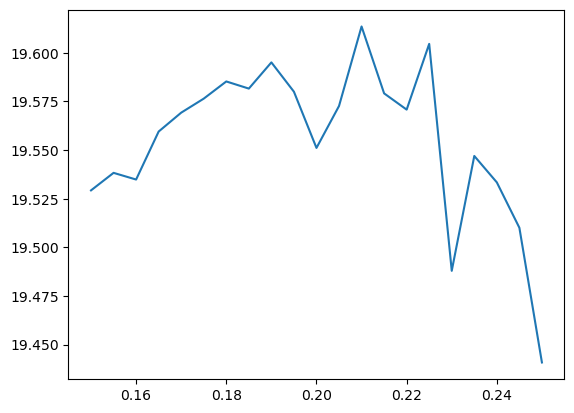

In [80]:
plt.plot(eccs, SNRs)
plt.show()